In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression as MR
from sklearn.linear_model import LinearRegression as LR
import statsmodels.api as sm 
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso as LLR
import statsmodels.api as sm 
from sklearn.datasets import make_sparse_uncorrelated
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 

In [2]:
from sklearn import datasets
from sklearn.linear_model import Lasso
from random import shuffle
wine = datasets.load_wine()

In [3]:
X=wine['data']
Y=wine['target']

In [4]:
XY=list(zip(X,Y))
shuffle(XY)
X,Y=list(zip(*XY))
X=np.array(X)
Y=np.array(Y)

In [5]:
alphas = [np.e**(x/10) for x in range(-100,-30)]
Scores=[]
for alpha in alphas:
    log_reg = LLR(alpha)
    kfold = KFold(n_splits=10)
    score = cross_val_score(log_reg, X[:100], Y[:100], cv = kfold)
    Scores.append(np.mean(score))
    print("alpha: %s, CV Score Avg: %s " % (alpha, np.mean(score)))

alpha: 4.5399929762484875e-05, CV Score Avg: 0.8440250995616039 
alpha: 5.017468205617531e-05, CV Score Avg: 0.8440410450162508 
alpha: 5.545159943217697e-05, CV Score Avg: 0.8440588856337321 
alpha: 6.128349505322217e-05, CV Score Avg: 0.8440781870862241 
alpha: 6.772873649085393e-05, CV Score Avg: 0.8440998050511384 
alpha: 7.485182988770063e-05, CV Score Avg: 0.8441232338632133 
alpha: 8.272406555663227e-05, CV Score Avg: 0.8441493587308668 
alpha: 9.142423147817332e-05, CV Score Avg: 0.8441779313531288 
alpha: 0.00010103940183709347, CV Score Avg: 0.8442091999728139 
alpha: 0.00011166580849011483, CV Score Avg: 0.8442440226210854 
alpha: 0.00012340980408667962, CV Score Avg: 0.844281671538812 
alpha: 0.00013638892648201145, CV Score Avg: 0.8443228605324524 
alpha: 0.00015073307509547656, CV Score Avg: 0.8443684979421923 
alpha: 0.0001665858109876336, CV Score Avg: 0.8444184869397006 
alpha: 0.00018410579366757928, CV Score Avg: 0.8444724072179477 
alpha: 0.00020346836901064428, CV 

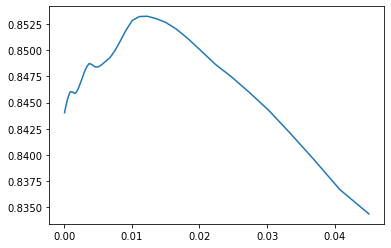

In [6]:
plt.plot(alphas,Scores)

In [7]:
alpha=alphas[np.argmax(Scores)] # best alpha

model=LLR(alpha).fit(X[:100], Y[:100])
Coef=model.coef_

In [8]:
rearange=Coef.argsort()
Coef.sort()
Coef[:5]=40
Coef[5:]=25

In [9]:
X=X[:,rearange[::-1]]
Coef.sort()
Coef=Coef[::-1]
font_size=Coef.astype(int)
grid=list(zip([0]*5+[145]*8,list(range(2,252,50))+list(range(2,252,32))))

In [10]:
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt


def sampletoimage(sample):
 img =  Image.fromarray(np.zeros((255,255)).astype('uint8'))
 draw = ImageDraw.Draw(img)    
 for f,s,g in zip(font_size,sample,grid):
  font = ImageFont.truetype("./LiberationMono-Bold.ttf", size=f)
  draw.text(g,str(s),font=font, fill='white')

 return [np.array(img) for _ in range(3)]

In [11]:
X=np.array(list(map(sampletoimage,X)))

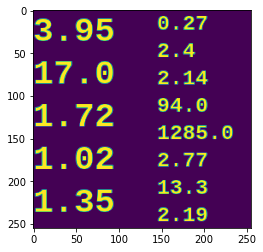

In [12]:
plt.imshow(X[3,0])

### ResNet18

In [14]:
import torch.nn as nn
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import torchvision
from torchvision import *

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [72]:
net = models.resnet18(pretrained=True)
num_features = net.fc.in_features
#net = torch.nn.Sequential(*(list(net.children())[:-1]))

In [75]:
net.layer4.

AttributeError: 'Sequential' object has no attribute 'requires_grad'

In [16]:
XX=[]
for inputs in torch.utils.data.DataLoader(X,batch_size=1):
 inputs = inputs.to('cpu', dtype=torch.float)
 XX.append(net(inputs).reshape(2048).detach().numpy())
XX=np.asarray(XX)

## Train Validation Test

In [59]:
def accuracy(pred,y):
    return sum(pred==y)/len(y)
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from sklearn.model_selection import KFold

device='cpu'
Train_stats=[]
Test_stats=[]
for fold, (train_index, test_index)  in enumerate(KFold(n_splits=5,shuffle=True).split(X)):
 train_data = torch.utils.data.DataLoader(list(zip(XX[train_index],Y[train_index])), batch_size=8, shuffle=True,num_workers=24)
 validation_data = torch.utils.data.DataLoader(list(zip(XX[test_index],Y[test_index])),batch_size=1024,num_workers=24) 

 net=  nn.Sequential(nn.Linear(num_features, 3), nn.Softmax(1))           
 net=net.to(device)
 #loss and optim
 criterion = nn.CrossEntropyLoss().to(device)
 optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)
 
 for epoch in range(5):
   
    Stats=[]
    Names=['Fold','Epoch','Accuracy','Loss']

    for i, (inputs, labels) in enumerate(train_data):
        net.train()
        inputs = inputs.to(device, dtype=torch.float); 
        labels=labels.to(device).long()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([fold+1,epoch+1,accuracy(pred,labels).item(),loss.item()])
    Train_stats.append({key:val for key,val in zip(Names,np.asarray(Stats).T)})
    print("-----      TRAIN RESULTS      -----")
    print({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})
 
    Stats=[]

    for i, (inputs, labels) in enumerate(validation_data):
        net.eval()
        inputs = inputs.to(device, dtype=torch.float);
        labels=labels.to(device).long()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([fold+1,epoch+1,accuracy(pred,labels).item(),loss.item()])   
    
    
    Test_stats.append({key:val for key,val in zip(Names,np.asarray(Stats).T)})
    print("-----       TEST RESULTS     ---")
    print({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})
 break

-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 1.0, 'Accuracy': 0.3564814817574289, 'Loss': 1.1021413273281522}
-----       TEST RESULTS     ---
{'Fold': 1.0, 'Epoch': 1.0, 'Accuracy': 0.3611111044883728, 'Loss': 1.1270184516906738}
-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 2.0, 'Accuracy': 0.40740740795930225, 'Loss': 1.1352683669990964}
-----       TEST RESULTS     ---
{'Fold': 1.0, 'Epoch': 2.0, 'Accuracy': 0.3611111044883728, 'Loss': 1.1766650676727295}
-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 3.0, 'Accuracy': 0.41203703814082676, 'Loss': 1.1136588818497128}
-----       TEST RESULTS     ---
{'Fold': 1.0, 'Epoch': 3.0, 'Accuracy': 0.3611111044883728, 'Loss': 1.1322458982467651}
-----      TRAIN RESULTS      -----
{'Fold': 1.0, 'Epoch': 4.0, 'Accuracy': 0.33564814842409557, 'Loss': 1.1044658654265933}
-----       TEST RESULTS     ---
{'Fold': 1.0, 'Epoch': 4.0, 'Accuracy': 0.3611111044883728, 'Loss': 1.1446399688720703}
-----      TRAIN 

In [60]:
test=pd.DataFrame(Test_stats[0]).iloc[1:]
for S in Test_stats:
 test=test.append(pd.DataFrame(S))

In [61]:
test.groupby('Epoch').sum(['Loss','Precision','Recall','f1_score'])

,Fold,Accuracy,Loss
Epoch,,,
1.0,1.0,0.361111,1.127018
2.0,1.0,0.361111,1.176665
3.0,1.0,0.361111,1.132246
4.0,1.0,0.361111,1.144640
5.0,1.0,0.361111,1.141729


In [62]:
train=pd.DataFrame(Train_stats[0]).iloc[1000:]
for S in Train_stats:
 train=train.append(pd.DataFrame(S))

In [64]:
train.groupby('Epoch').sum(['Loss','Precision','Recall','f1_score'])/18

,Fold,Accuracy,Loss
Epoch,,,
1.0,1.0,0.356481,1.102141
2.0,1.0,0.407407,1.135268
3.0,1.0,0.412037,1.113659
4.0,1.0,0.335648,1.104466
5.0,1.0,0.405093,1.115512
